# Twitter Sentiment Analysis
Dataset contains nearly 32K tweets which are labeled based on having racist or sexist content. We are going to analyse this dataset and tweets, and by the end, create a classification model to classify tweets.

In [2]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from wordcloud import WordCloud


from matplotlib import style
style.available

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
data = pd.read_csv('twitter-train.csv')
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
print("Hatred labelled: {}\nNon-hatred labelled: {}".format( (data.label == 1).sum(), 
                                                            (data.label == 0).sum() ))

Hatred labelled: 2242
Non-hatred labelled: 29720


## Extracting features
### Hashtags and mentions
We'll extract hashtags for each tweet as an extra column to explore them later.
For user mentions, all of the usernames have been replaced with 'user' so we can't get any data from it, we'll just remove mentions and keep the number of mentions in each tweet as an extra features for that tweet

In [5]:
hashtags = data['tweet'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))
data.loc[:, 'hashtags'] = hashtags['hashtag']
data['hashtags'].fillna('', inplace=True)

data.loc[:, 'mentions'] = data['tweet'].str.count('@[a-zA-Z0-9_]+')

data.tweet = data.tweet.str.replace('@[a-zA-Z0-9_]+', '')

### Removing anything but the words
Now we'll remove anything but the words (punctuations, numbers, etc). Note that this time we'll replace them with a blank space since it might be a `_` or `-` or a punctuation with no space from the next word and we don't want the words to join together

In [6]:
data.tweet = data.tweet.str.replace('[^a-zA-Z]', ' ')

### Lemmatization
We lemmatize tweets' words as we have the sentences and we can tag part of speeches, and will stem hashtags.

In [7]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, FreqDist, word_tokenize

In [8]:
stemmer = SnowballStemmer('english')
lemmer = WordNetLemmatizer()

part = {
    'N' : 'n',
    'V' : 'v',
    'J' : 'a',
    'S' : 's',
    'R' : 'r'
}

def convert_tag(penn_tag):
    if penn_tag in part.keys():
        return part[penn_tag]
    else:
        return 'n'
    
def tag_and_lem(element):
    sent = pos_tag(word_tokenize(element))
    return ' '.join([lemmer.lemmatize(sent[k][0], convert_tag(sent[k][1][0])) 
                     for k in range(len(sent))])

data.loc[:, 'tweet'] = data['tweet'].apply(lambda x: tag_and_lem(x))

data.loc[:, 'hashtags'] = data['hashtags'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

### Frequent words
Now let's see what words and hashtags are the most frequenst in hate tweets and in total.

<IPython.core.display.Javascript object>


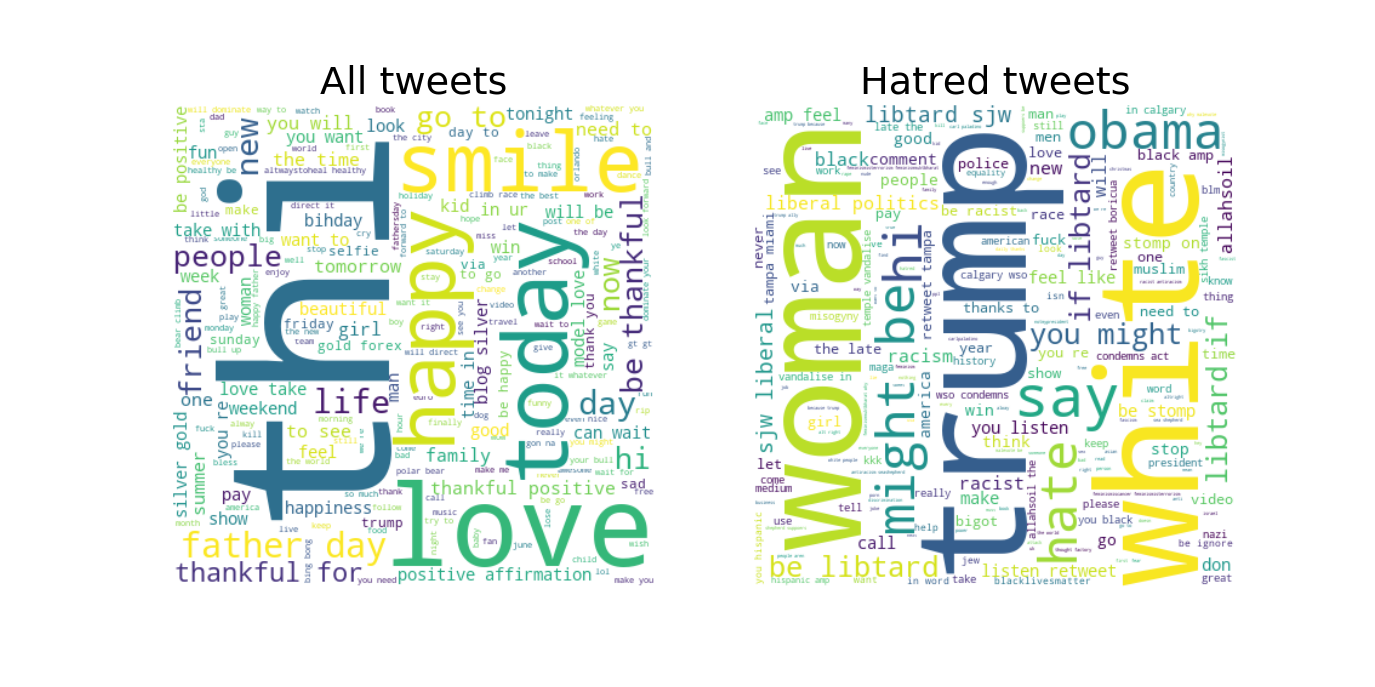

In [14]:
from wordcloud import WordCloud, STOPWORDS
stopwords = STOPWORDS.add('amp')

all_words = ' '.join(data.tweet.values)
hatred_words = ' '.join(data[data.label == 1].tweet.values)

plt.figure(figsize=(10, 5))

cloud1 = WordCloud(width=400, height=400, background_color='white',
                  stopwords=stopwords).generate(all_words)

plt.subplot(121)
plt.imshow(cloud1, interpolation='bilinear')
plt.axis("off")
plt.title('All tweets', size=20)


cloud2 = WordCloud(width=400, height=400, background_color='white',
                  stopwords=stopwords).generate(hatred_words)

plt.subplot(122)
plt.imshow(cloud2, interpolation='bilinear')
plt.axis("off")
plt.title('Hatred tweets', size=20)
plt.show()


### Hashtags
Now let's see which hashtags are used the most in hatred tweets and in total.

<IPython.core.display.Javascript object>


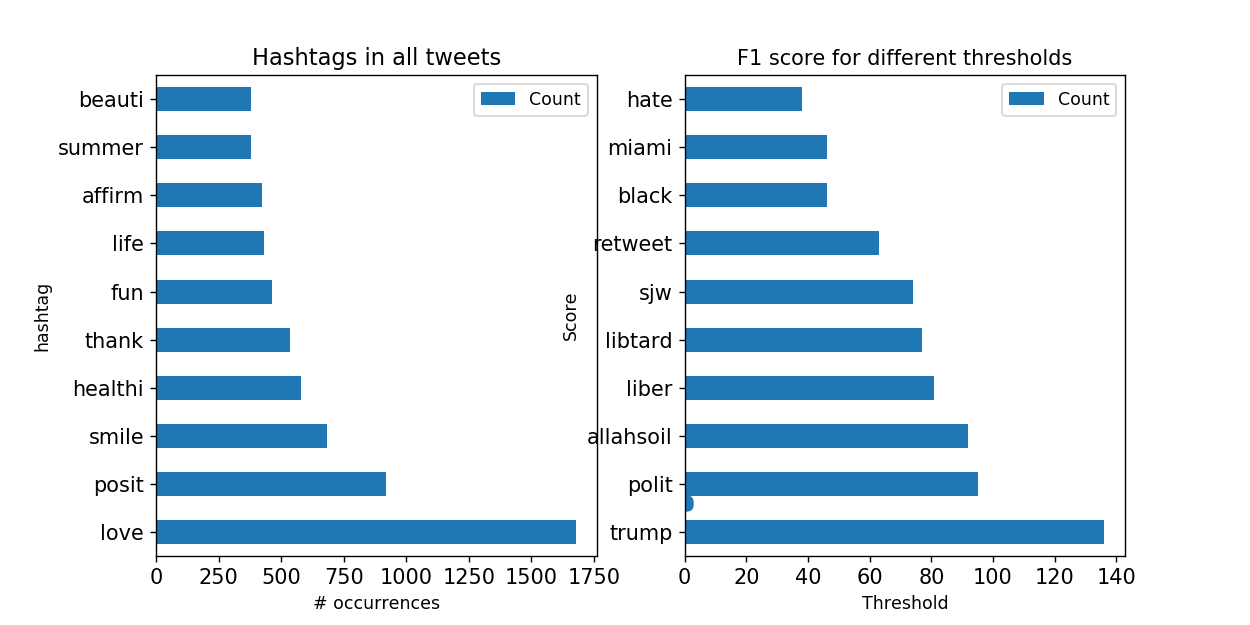

In [16]:
all_hashtags = FreqDist(list(' '.join(data.hashtags.values).split())).most_common(10)

hatred_hashtags = FreqDist(list(' '.join(data[data.label == 1].hashtags.values).split())).most_common(10)

plt.figure(figsize=(10, 5))

ax = plt.subplot(121)
pd.DataFrame(all_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.title('Hashtags in all tweets', size=13)

ax = plt.subplot(122)
pd.DataFrame(hatred_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.title('Hashtags in hatred tweets', size=13)

plt.show()

### Mentions
Let's see how many mentions are there in total and if they can be of any use

In [17]:
print("Number of mentions: {}\nNumber of tweets having a mentions: {}\nCorrelation with label: {}".format(
     data.mentions.sum(), len(data[data.mentions > 0]), np.corrcoef(data.mentions, data.label)[0][1]))

Number of mentions: 17571
Number of tweets having a mentions: 11126
Correlation with label: 0.07851491623991753


In [18]:
data.drop('mentions', axis=1, inplace=True)

### Tfidf vectorizing
Now we use the frequency of each word in tweets as our features

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3), min_df=10)
features = vectorizer.fit_transform(data.tweet)

### Classifying
We'll build a SVC and a LogsiticRegression model for classifying our tweets.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(features, data.label)

### LogisticRegression

Best parameters found were {'C': 30, 'penalty': 'l2'} with F1 score of 0.64


<IPython.core.display.Javascript object>


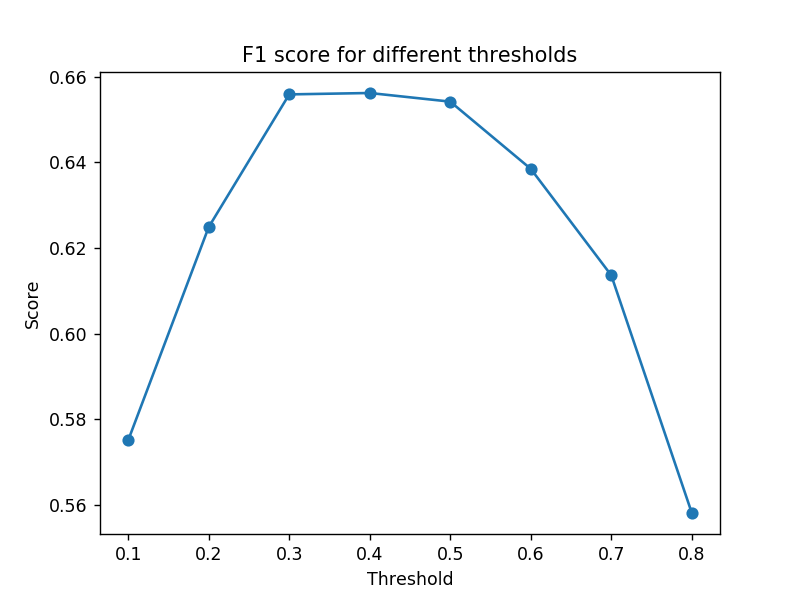

In [25]:
params = {'penalty' : ['l1', 'l2'], 'C': [3, 10, 30, 100, 300]}

lrmodel = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=150), 
                       param_grid=params, scoring='f1', cv=5, n_jobs=-1)

lrmodel.fit(X_train, y_train)

print("Best parameters found were {} with F1 score of {:.2f}".format(
lrmodel.best_params_, lrmodel.best_score_))


probas = lrmodel.predict_proba(X_test)
thresholds = np.arange(0.1, 0.9, 0.1)
scores = [f1_score(y_test, (probas[:, 1] >= x).astype(int)) for x in thresholds]

plt.figure()
plt.plot(thresholds, scores, 'o-')
plt.title("F1 score for different thresholds")
plt.ylabel("Score")
plt.xlabel("Threshold")
plt.show()

### SVC

In [26]:
params = {'C' : [1000, 3000, 9000, 15000]}

svc = GridSearchCV(SVC(kernel='rbf', gamma='auto'), param_grid=params, 
                   scoring='f1', cv=3, n_jobs=-1)
svc.fit(X_train , y_train)
print("Best parameter founds were {} with F1 score of {:.2f}".format(
svc.best_params_, svc.best_score_))

predictions = svc.predict(X_test)
print("\nF1 test score for SVC: {:.2f}".format(f1_score(y_test, predictions)))

Best parameter founds were {'C': 9000} with F1 score of 0.63

F1 test score for SVC: 0.65


### Conclusion
We saw some of the most common words and hashtags in general and in racist/sexist tweets, extracted features by counting word tokens and Tfidf weighting them. We used unigrams, bigrams and trigrams as tokens.
Finally, we built a logistic regression model and a support vector classifier to classify future tweets in these 2 classes.